# Twitter Analysis

트위터의 스트림 데이터를 활용하여 실습을 진행한다.  
이를 위해서 아래 링크에서 트위터 디벨로퍼 가입이 필요하다.  
https://developer.twitter.com/  
  
가입이 조금 귀찮지만 하고나면 다음과 같은 페이지에 접근된다.
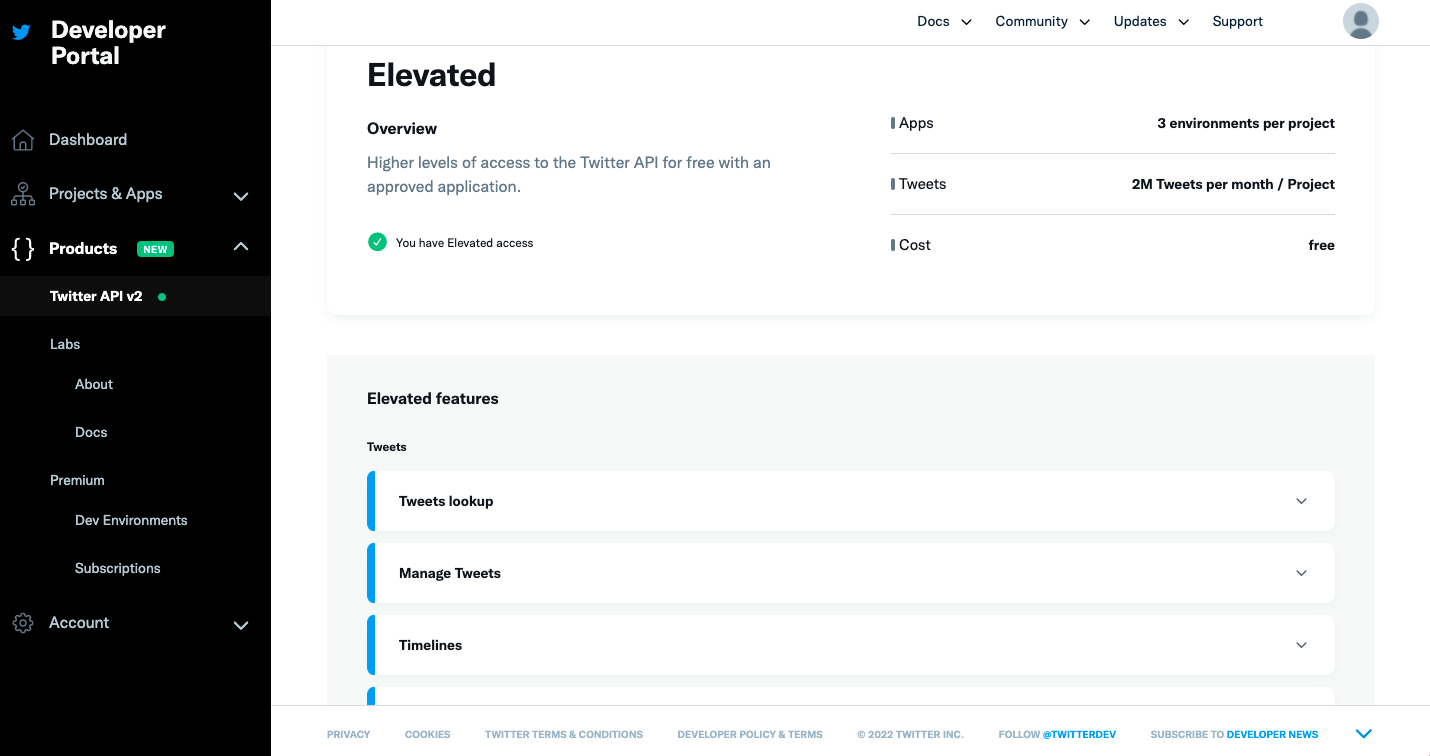  

--------

Projects & Apps에서 프로젝트를 만든다.  
해당 과정도 조금 귀찮을 수 있다.  
이후 생성한 프로젝트의 key를 활용해야하는데 git에 올릴거기 때문에 key들을 TwitterConfig 클래스에 넣고 gitignore에 "Flink/twitter/TwitterConfig.py"를 추가해서 key 정보가 git에 노출되지 않도록 했다.  
gitignore에 추가하고도 스테이지에 올라가있길래 https://jojoldu.tistory.com/307 여기서 시키는 대로 캐시를 삭제하고 올리니까 됐다.

-------
해당 API로 트위터에 올라오는 데이터 중에 한국어 트윗의 텍스트를 스트림으로 받아서 kafka producer로 올리는 코드는 다음과 같다.

In [ ]:
 import tweepy
import json 
from kafka import KafkaProducer
from TwitterConfig import TwitterConfig

config = TwitterConfig()
consumer_key=config.consumer_key
consumer_secret=config.consumer_secret
access_token=config.access_token
access_token_secret=config.access_token_secret


producer = KafkaProducer(bootstrap_servers=["localhost:9092"])

class ProcessStream(tweepy.Stream):
  def on_data(self, raw_data):
    data = json.loads(raw_data)
    if "lang" in data and data["lang"] == "ko":
      korean_tweet = {
        "text": data["text"],
        "timestamp_ms": data["timestamp_ms"]
      }
      producer.send("korean-tweets", json.dumps(korean_tweet).encode("utf-8"))

twitter_stream = ProcessStream(
  consumer_key,
  consumer_secret,
  access_token,
  access_token_secret
)

twitter_stream.filter(track=["Twitter"])

위 파일을 실행시키면 다음과 같이 korean-tweets 토픽이 생성되고
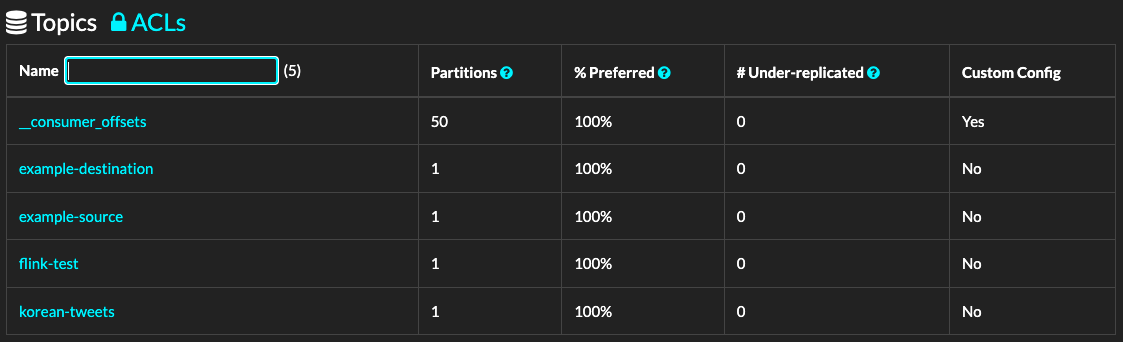  
토픽에 들어가면 다음과 같이 순식간에 데이터가 쌓인 것을 확인할 수 있다.
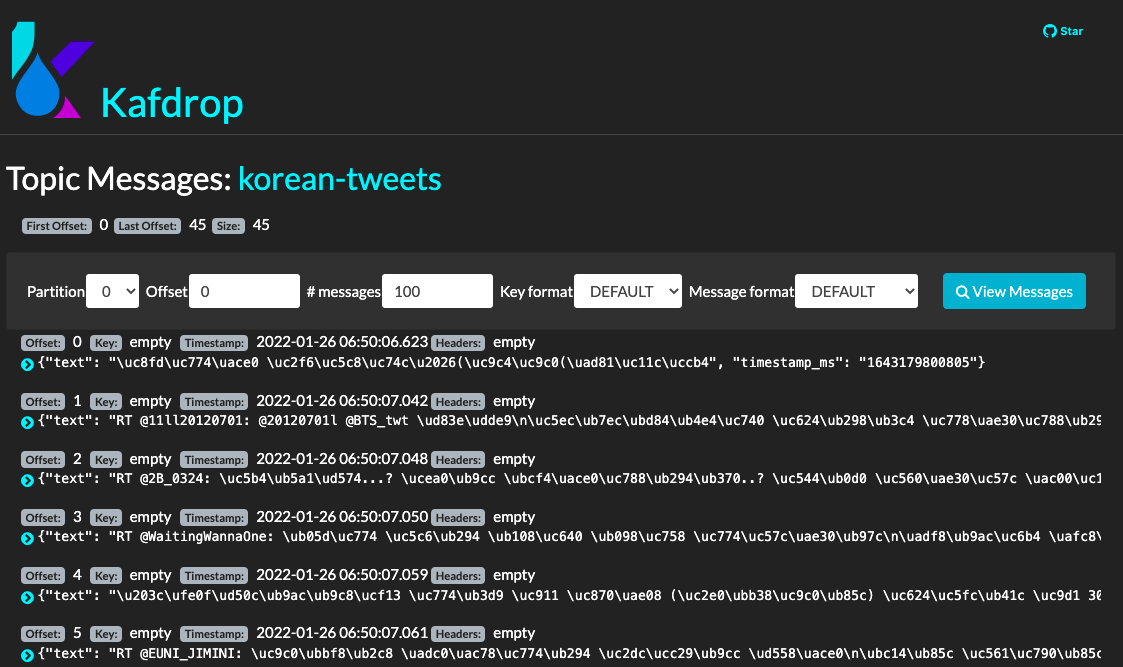

이후 다음과 같이 udf를 활용하여 트위터에 올라오는 텍스트의 단어 수를 세는 프로그램 작성 예시를 twitter_word_count.py 파일에서 확인할 수 있다.

In [ ]:
import os
from pyflink.datastream import StreamExecutionEnvironment
from pyflink.table import StreamTableEnvironment, EnvironmentSettings, DataTypes
from pyflink.table.udf import udf 

env = StreamExecutionEnvironment.get_execution_environment()
env.set_parallelism(1)
settings = EnvironmentSettings.new_instance().in_streaming_mode().use_blink_planner().build()
t_env = StreamTableEnvironment.create(env, environment_settings=settings)

kafka_jar_path = os.path.join(
  os.path.abspath(os.path.dirname(__file__)), "../",
  "flink-sql-connector-kafka_2.11-1.14.2.jar"
)
t_env.get_config().get_configuration().set_string(
  "pipeline.jars", f"file://{kafka_jar_path}"
)

source_query = """
  CREATE TABLE tweets (
    text STRING,
    timestamp_ms BIGINT,
    ts AS TO_TIMESTAMP_LTZ(timestamp_ms, 3),
    WATERMARK FOR ts AS ts - INTERVAL '5' SECOND
  ) WITH (
    'connector' = 'kafka',
    'topic' = 'korean-tweets',
    'properties.bootstrap.servers' = 'localhost:9092',
    'properties.group.id' = 'tweet-group',
    'format' = 'json',
    'scan.startup.mode' = 'latest-offset'
  )
"""

sink_query = """
  CREATE TABLE sink (
    word_count STRING,
    w_start TIMESTAMP(3),
    w_end TIMESTAMP(3)
  ) WITH (
    'connector' = 'print'
  )
"""

t_env.execute_sql(source_query)
t_env.execute_sql(sink_query)

# t_env.from_path("tweets").execute_insert("sink").wait()

windowed = t_env.sql_query("""
  SELECT 
    text,
    HOP_START(ts, INTERVAL '2' SECONDS, INTERVAL '10' SECONDS) AS w_start,
    HOP_END(ts, INTERVAL '2' SECONDS, INTERVAL '10' SECONDS) AS w_end
  FROM tweets
  GROUP BY
    HOP(ts, INTERVAL '2' SECONDS, INTERVAL '10' SECONDS),
    text
""")

@udf(result_type=DataTypes.STRING())
def word_count(data):
  word_list = data.split()
  counter = {}
  for word in word_list:
    if word not in counter:
      counter[word] = 1
    else:
      counter[word] += 1
  return str(counter)

res = windowed.select(word_count(windowed.text).alias("word_count"), windowed.w_start, windowed.w_end)
res.execute_insert("sink").wait()